In [ ]:
pip install deepface

In [ ]:
from google.colab import drive
drive.mount('content')

In [ ]:
!ls 'content/MyDrive/Screenshot_3.jpg'

In [ ]:
import cv2
import math
from deepface import DeepFace
import matplotlib.pyplot as plt

In [ ]:
img = cv2.imread('content/MyDrive/Screenshot_3.jpg')

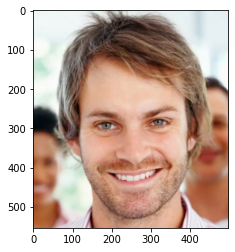

In [ ]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [ ]:
DeepFace.analyze(img, actions=['emotion'])

{'dominant_emotion': 'happy',
 'emotion': {'angry': 3.073237549996522e-13,
  'disgust': 2.5523649808689202e-21,
  'fear': 5.071564690341739e-16,
  'happy': 99.99784231185913,
  'neutral': 0.0021602776541840285,
  'sad': 2.1538855226287124e-11,
  'surprise': 1.1729552225336892e-09},
 'region': {'h': 351, 'w': 351, 'x': 76, 'y': 153}}

In [ ]:
DeepFace.analyze(img, actions=['emotion'])['dominant_emotion']

'happy'

In [ ]:
def time_calculation(frame_num: int, start_frame: int, fps: float) -> tuple:
  """
  По числу кадров вычисляется временной промежуток,
  на протяжении которого длилась какая-нибудь эмоция

  Параметры
  ----------
  frame_num: число кадров, длившейся эмоции
  start_frame: номер кадра, в который начинается эмоция
  fps: число кадров в секунде видео

  Возвращаемые значения
  ----------
  start_time: строка, содержащая начало временного промежутка
  end_time: строка, содержащая конец временного промежутка
  """

  start_hours = int((start_frame / fps) // 60 // 60)
  start_minutes = int((start_frame / fps) // 60 - start_hours * 60)
  start_seconds = int(round((start_frame / fps)
                      - start_minutes * 60
                      - start_hours * 60 * 60))
  

  end_hours = int(((start_frame + frame_num) / fps) // 60 // 60)
  end_minutes = int(((start_frame + frame_num) / fps) // 60 - end_hours * 60)
  end_seconds = int(math.floor(((start_frame + frame_num) / fps) 
                    - end_minutes * 60 
                    - end_hours * 60 * 60))
  
  start_time = (str(start_hours) 
                + ':' + str(start_minutes) 
                + ':' + str(start_seconds))
  end_time = (str(end_hours) 
              + ':' + str(end_minutes) 
              + ':' + str(end_seconds))

  return start_time, end_time

In [ ]:
def show_model_result(results):
    for result in results:
        start_minutes, start_seconds = result[0].split(':')[1:]
        end_minutes, end_seconds = result[1].split(':')[1:]
        emotion = result[2]
        if int(start_minutes): 
            print(f'с {start_minutes} минуты {start_seconds} секунды по \
{end_minutes} минуту {end_seconds} секунду - {emotion}')
        else:
            print(f'с {start_seconds} секунды по \
{end_seconds} секунду - {emotion}')

In [ ]:
show_model_result([['0:1:6', '0:1:7', 'sad'],
 ['0:0:8', '0:0:11', 'angry'],
 ['0:0:12', '0:0:24', 'neutral'],
 ['0:2:25', '0:3:27', 'surprise'],
 ['0:0:27', '0:0:30', 'angry']])

с 1 минуты 6 секунды по 1 минуту 7 секунду - sad
с 8 секунды по 11 секунду - angry
с 12 секунды по 24 секунду - neutral
с 2 минуты 25 секунды по 3 минуту 27 секунду - surprise
с 27 секунды по 30 секунду - angry


In [ ]:
def emotion_recognition_final(
    name_of_video: str, 
    pos_time_w_face_outside: int = 0.2,
    num_of_fr_per_step: int = 1,
    accelerated_version_flag = False
    ) -> list:
    """
    Описание:
    В функции совершается проход по всем кадрам видео и определяется эмоция 
    Далее вычисляются временные промежутки для каждой эмоции.

    Параметры
    ----------
    name_of_video : имя видео, включающее расширение
    num_of_fr_per_step: число кадров считывающихся из видео за шаг цикла
    pos_time_w_face_outside: кол-во секунд, которое должно пройти, чтобы считать,
    что эмоция изменилась
    accelerated_version_flag : флаг, устанавливающий версию, которая проходится
    по каждому второму кадру, соответственно работающую быстрее, но падает точность
    ----------
    """
    def show_model_result(results, flag):
        if len(results) == 1 and not results[0][-1]: # если видео без лица
            print('На видео нет ни одной эмоции')
        else:
            for result in results:
                start_minutes, start_seconds = result[0].split(':')[1:]
                end_minutes, end_seconds = result[1].split(':')[1:]
                emotion = result[2]
                if int(start_minutes): 
                    print(f'с {start_minutes} минуты {start_seconds} секунды по \
{end_minutes} минуту {end_seconds} секунду - {emotion}')
                else:
                    print(f'с {start_seconds} секунды по \
{end_seconds} секунду - {emotion}')
                
    list_of_periods = []
    input_lect = cv2.VideoCapture(name_of_video) 
    fps = input_lect.get(cv2.CAP_PROP_FPS)  # Число кадров в секунде видео
    pos_num_of_frames = fps * pos_time_w_face_outside  # Кол-во кадров, которое 
                                                      # должно быть считано,
                                                      # чтобы эмоция считалась
                                                      # изменившейся
    frames_w_real_emotion = -1    # количество кадров, действующей эмоции, идущих подряд
    frames_w_real_emotion_st = 0  # номер кадра, с которого эмоция стала действующей
    frames_w_new_emotion = -1     # количество кадров, новой эмоции, идущих подряд
    frames_w_new_emotion_st = 0   # номер кадра, с которого началась новая эмоция
    new_emotion = None

    number_of_frame = 0  # Номер текущего кадра
    flag = True  # флаг чтобы установить действующей какую-то эмоцию
    first_new_emotion_flag = False
    if accelerated_version_flag:
        k = 0
        num_of_fr_per_step = 2
    else:
        num_of_fr_per_step = 1

    while True:  # Проходим в цикле по всем кадрам исходного видео
        if accelerated_version_flag:
            k += 1
            if k % 2 == 1:
                continue
        face_is_find = True  # Найдено ли лицо на текущем кадре

        number_of_frame += num_of_fr_per_step  # Увеличиваем счетчик кадров 

        for i in range(num_of_fr_per_step):  # Считываем нужное число кадров
            ret, frame = input_lect.read()     # из видео 

        if ret == False:  # Когда доходим до конца видео, прерываем цикл
            break
        
        try:
            previous_emotion, \
            new_emotion = new_emotion, \
            DeepFace.analyze(frame, actions=['emotion'])['dominant_emotion']
            if flag:
                real_emotion = new_emotion
                frames_w_real_emotion += num_of_fr_per_step
                frames_w_real_emotion_st = number_of_frame
                flag = False
                continue
        except ValueError: # на кадре нет лица
            if frames_w_real_emotion > pos_num_of_frames: 
                  start_time, end_time = time_calculation(frames_w_real_emotion,                  
                                                          frames_w_real_emotion_st,
                                                          fps)
                  list_of_periods.append([start_time, end_time, real_emotion])
                  
            real_emotion = None
            flag = True 
            frames_w_real_emotion = -1
            frames_w_real_emotion_st = 0
            frames_w_new_emotion = -1
            frames_w_new_emotion_st = 0
            continue
        
        if new_emotion != real_emotion:
            if previous_emotion == new_emotion:
                frames_w_new_emotion += num_of_fr_per_step  
            else:     
                frames_w_new_emotion = -1
                frames_w_new_emotion_st = number_of_frame   

            if frames_w_new_emotion > pos_num_of_frames and \
            frames_w_real_emotion > pos_num_of_frames:
                start_time, end_time = time_calculation(frames_w_real_emotion,                 
                                                        frames_w_real_emotion_st,
                                                        fps)
                list_of_periods.append([start_time, end_time, real_emotion])
                real_emotion = new_emotion
                frames_w_real_emotion = 0 
                frames_w_real_emotion_st = number_of_frame
            else:
                frames_w_real_emotion += num_of_fr_per_step
        else:
            frames_w_real_emotion += num_of_fr_per_step
    start_time, end_time = time_calculation(frames_w_real_emotion,                  
                                            frames_w_real_emotion_st,
                                            fps)
    list_of_periods.append([start_time, end_time, real_emotion])
    show_model_result(list_of_periods, flag)

In [ ]:
emotion_recognition_final('content/MyDrive/karpov_720_cropped.mp4')

In [ ]:
from google.colab import drive
drive.mount('content')

Mounted at content


In [ ]:
emotion_recognition_final('content/MyDrive/IMG_3230.MP4', accelerated_version_flag=True)

facial_expression_model_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/facial_expression_model_weights.h5
To: /root/.deepface/weights/facial_expression_model_weights.h5
100%|██████████| 5.98M/5.98M [00:00<00:00, 77.0MB/s]


с 0 секунды по     2 секунду - fear
с 3 секунды по     3 секунду - fear
с 4 секунды по     4 секунду - sad
с 5 секунды по     5 секунду - neutral
с 6 секунды по     6 секунду - sad
с 6 секунды по     8 секунду - fear
с 8 секунды по     8 секунду - neutral


In [ ]:
emotion_recognition_final('content/MyDrive/IMG_3230.MP4', accelerated_version_flag=True)

с 0 секунды по   2 секунду - fear
с 3 секунды по   3 секунду - fear
с 4 секунды по   4 секунду - sad
с 5 секунды по   5 секунду - neutral
с 6 секунды по   6 секунду - sad
с 6 секунды по   8 секунду - fear
с 8 секунды по   8 секунду - neutral


In [ ]:
emotion_recognition_final('content/MyDrive/karpov_720_cropped.mp4', accelerated_version_flag=True)

с 0 секунды по 4 секунду - neutral
с 5 секунды по 10 секунду - angry


In [ ]:
emotion_recognition_final('content/MyDrive/IMG_3313.MP4', accelerated_version_flag=True)

На видео нет ни одной эмоции


In [ ]:
emotion_recognition_final('content/MyDrive/index (2)_Trim_Trim.mp4', accelerated_version_flag=False)

с 0 секунды по     2 секунду - surprise
с 3 секунды по     4 секунду - neutral
с 4 секунды по     6 секунду - fear
с 6 секунды по     8 секунду - happy
с 8 секунды по     12 секунду - neutral
с 13 секунды по     15 секунду - happy
с 16 секунды по     16 секунду - disgust
с 16 секунды по     17 секунду - angry
с 18 секунды по     21 секунду - happy
с 22 секунды по     23 секунду - fear
с 24 секунды по     25 секунду - angry


In [ ]:
emotion_recognition_final('content/MyDrive/lect_econom (online-video-cutter.com).mp4', accelerated_version_flag=True)

с 6 секунды по 7 секунду - sad
с 8 секунды по 11 секунду - angry
с 12 секунды по 13 секунду - neutral
с 13 секунды по 15 секунду - sad
с 16 секунды по 24 секунду - neutral
с 25 секунды по 27 секунду - surprise
с 27 секунды по 28 секунду - angry
с 29 секунды по 30 секунду - neutral


In [ ]:
emotion_recognition_final('content/MyDrive/index (online-video-cutter.com).mp4', accelerated_version_flag=False)

с 0 секунды по 3 секунду - surprise
с 4 секунды по 4 секунду - neutral
с 4 секунды по 7 секунду - happy
с 7 секунды по 11 секунду - neutral
с 11 секунды по 12 секунду - happy
с 13 секунды по 14 секунду - neutral
с 14 секунды по 15 секунду - happy
с 15 секунды по 16 секунду - angry
с 17 секунды по 19 секунду - happy
